## Notebook to test an ensemble learning model of the top 3-5 model from Algorithm_Test_3

In [17]:
#Imports
import numpy as np
import pandas as pd
import sys, os, random
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from datetime import datetime
import json
import joblib

#Warning Supression
import warnings
warnings.filterwarnings("ignore", module="skopt") #Ignore scikit-optimize warning print lines
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning) #For QDA
warnings.filterwarnings("ignore", category=UserWarning) #For LightBoost

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import ML_Class_2
importlib.reload(ML_Class_2) #Ensures file is uptodate!
from src.models.ML_Class_2 import Model_Tester_V2

#Utils Import
from src.models.model_artifacts import (get_artifact_dir, load_model, load_models, save_model, save_models,)
ARTIFACT_DIR = get_artifact_dir("algorithm_test_3")
from src.models import model_specs
importlib.reload(model_specs) #Ensures file is uptodate!
from src.models.model_specs import MODEL_SPECS
from src.models.perf_utils import track_performance

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [3]:
# --- Data Loading and Preprocessing --- 

#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape #Test
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)
#Feature Names for later feature analysis:
feature_names = list(df)
feature_names[:-1] #Drop Risk (y)
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [ ]:
# --- Extra Trees ---

spec = MODEL_SPECS["et"]
et = Model_Tester_V2(
    model=spec["estimator"],
    parameter_grid=spec["grid_large"],
    cv_folds=5,
    feature_names=feature_names,
    model_config=spec["config"],)
et.train_test_split(X, y, train_size=0.8, random_state=1945)

#Load trained model
load_model("et", directory=ARTIFACT_DIR, assign_to=et)
et_results = et.evaluate(show_plots=False)

Applied decision threshold: 0.5968

ExtraTreesClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       185
           1       0.69      0.62      0.65        50

    accuracy                           0.86       235
   macro avg       0.79      0.77      0.78       235
weighted avg       0.86      0.86      0.86       235


ROC AUC Score: 0.8123
Matthews Correlation Coefficient (MCC): 0.5662
Balanced Accuracy: 0.7722
ExtraTreesClassifier Confusion Matrix:
[[171  14]
 [ 19  31]]


In [6]:
# --- Random Forest ---

spec = MODEL_SPECS["rf"]
rf = Model_Tester_V2(
    model=spec["estimator"],
    parameter_grid=spec["grid_large"],
    cv_folds=5,
    feature_names=feature_names,
    model_config=spec["config"],)
rf.train_test_split(X, y, train_size=0.8, random_state=1945)

#Load trained model
load_model("rf", directory=ARTIFACT_DIR, assign_to=rf)
rf_results = rf.evaluate(show_plots=False)

Applied decision threshold: 0.5057

RandomForestClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       185
           1       0.64      0.60      0.62        50

    accuracy                           0.84       235
   macro avg       0.77      0.75      0.76       235
weighted avg       0.84      0.84      0.84       235


ROC AUC Score: 0.8128
Matthews Correlation Coefficient (MCC): 0.5199
Balanced Accuracy: 0.7541
RandomForestClassifier Confusion Matrix:
[[168  17]
 [ 20  30]]


In [7]:
# --- GradientBoosting ---

spec = MODEL_SPECS["gb"]
gb = Model_Tester_V2(
    model=spec["estimator"],
    parameter_grid=spec["grid_large"],
    cv_folds=5,
    feature_names=feature_names,
    model_config=spec["config"],)
gb.train_test_split(X, y, train_size=0.8, random_state=1945)

#Load trained model
load_model("gb", directory=ARTIFACT_DIR, assign_to=gb)
gb_results = gb.evaluate(show_plots=False)

Applied decision threshold: 0.9907

GradientBoostingClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       185
           1       0.71      0.20      0.31        50

    accuracy                           0.81       235
   macro avg       0.77      0.59      0.60       235
weighted avg       0.80      0.81      0.77       235


ROC AUC Score: 0.7845
Matthews Correlation Coefficient (MCC): 0.3084
Balanced Accuracy: 0.5892
GradientBoostingClassifier Confusion Matrix:
[[181   4]
 [ 40  10]]


In [9]:
# --- AdaBoostClassifier ---

#Notes: Compare With GB once new param grid is fit

spec = MODEL_SPECS["ada"]
ada = Model_Tester_V2(
    model=spec["estimator"],
    parameter_grid=spec["grid_large"],
    cv_folds=5,
    feature_names=feature_names,
    model_config=spec["config"],)
ada.train_test_split(X, y, train_size=0.8, random_state=1945)

#Load trained model
load_model("ada", directory=ARTIFACT_DIR, assign_to=ada)
ada_results = ada.evaluate(show_plots=False)

Applied decision threshold: 0.6515

AdaBoostClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       185
           1       0.54      0.62      0.58        50

    accuracy                           0.81       235
   macro avg       0.72      0.74      0.73       235
weighted avg       0.82      0.81      0.81       235


ROC AUC Score: 0.7818
Matthews Correlation Coefficient (MCC): 0.4578
Balanced Accuracy: 0.7397
AdaBoostClassifier Confusion Matrix:
[[159  26]
 [ 19  31]]


In [ ]:
# --- QuadraticDiscriminantAnalysis ---

spec = MODEL_SPECS["qda"]
qda = Model_Tester_V2(
    model=spec["estimator"],
    parameter_grid=spec["grid_large"],
    cv_folds=5,
    feature_names=feature_names,
    model_config=spec["config"],)
qda.train_test_split(X, y, train_size=0.8, random_state=1945)

#Load trained model
load_model("qda", directory=ARTIFACT_DIR, assign_to=qda)
qda_results = qda.evaluate(show_plots=False)

Applied decision threshold: 0.4781

QuadraticDiscriminantAnalysis Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       185
           1       0.48      0.70      0.57        50

    accuracy                           0.77       235
   macro avg       0.69      0.75      0.71       235
weighted avg       0.82      0.77      0.79       235


ROC AUC Score: 0.7897
Matthews Correlation Coefficient (MCC): 0.4374
Balanced Accuracy: 0.7473
QuadraticDiscriminantAnalysis Confusion Matrix:
[[147  38]
 [ 15  35]]


In [10]:
# --- XGBRFClassifier ---

spec = MODEL_SPECS["xgbrf"]
xgbrf = Model_Tester_V2(
    model=spec["estimator"],
    parameter_grid=spec["grid_large"],
    cv_folds=5,
    feature_names=feature_names,
    model_config=spec["config"],)
xgbrf.train_test_split(X, y, train_size=0.8, random_state=1945)

#Load trained model
load_model("xgbrf", directory=ARTIFACT_DIR, assign_to=xgbrf)
xgbrf_results = xgbrf.evaluate(show_plots=False)

Applied decision threshold: 0.6253

XGBRFClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       185
           1       0.53      0.64      0.58        50

    accuracy                           0.80       235
   macro avg       0.72      0.74      0.73       235
weighted avg       0.82      0.80      0.81       235


ROC AUC Score: 0.7942
Matthews Correlation Coefficient (MCC): 0.4586
Balanced Accuracy: 0.7443
XGBRFClassifier Confusion Matrix:
[[157  28]
 [ 18  32]]


In [ ]:
# Preliminary soft-voting ensemble using loaded top models (swap tuned params/threshold later)
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef,
    balanced_accuracy_score, f1_score, precision_score, recall_score,)
import pandas as pd
import numpy as np

#Get Pre-loaded Models
xgbrf_base = xgbrf.best_model
qda_base = qda.best_model
ada_base = ada.best_model
rf_base = rf.best_model
et_base = et.best_model

#Use the same train/test split as above
X_train, X_test, y_train, y_test = xgbrf.X_train, xgbrf.X_test, xgbrf.y_train, xgbrf.y_test

#Soft voting ensemble (preliminary test)
voter = VotingClassifier(
    estimators=[('xgbrf', xgbrf_base), ('qda', qda_base), ('ada', ada_base), ('rf', rf_base), ('et', et_base)],
    voting='soft',
    n_jobs=-1,)
voter.fit(X_train, y_train)

#Predict with adjustable decision threshold
threshold = 0.5  
proba_1 = voter.predict_proba(X_test)[:, 1]
y_pred = (proba_1 >= threshold).astype(int)

#Metrics:
roc_auc = roc_auc_score(y_test, proba_1)
acc = np.mean(y_pred == y_test)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
precision_1 = precision_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)
mcc = matthews_corrcoef(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Threshold: {threshold:.2f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Recall (class 1): {recall_1:.3f}")
print(f"Precision (class 1): {precision_1:.3f}")
print(f"F1 (class 1): {f1_1:.3f}")
print(f"MCC: {mcc:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
print('\nConfusion Matrix:')
print(cm)

print('\nClassification Report (digits=3):')
print(classification_report(y_test, y_pred, digits=3))

#Metric DF:
ensemble_results = pd.DataFrame([{
    'Model': 'VotingEnsemble_5Models',
    'Threshold': threshold,
    'Acc': acc,
    'ROC_AUC': roc_auc,
    'MCC': mcc,
    'Bal_Acc': bal_acc,
    'Recall_1': recall_1,
    'Precision_1': precision_1,
    'F1_1': f1_1,}])
# display(ensemble_results) 


Threshold: 0.50
ROC AUC: 0.835
Accuracy: 0.813
Recall (class 1): 0.640
Precision (class 1): 0.552
F1 (class 1): 0.593
MCC: 0.474
Balanced Accuracy: 0.750

Confusion Matrix:
        Pred 0  Pred 1
True 0     159      26
True 1      18      32

Classification Report (digits=3):
              precision    recall  f1-score   support

           0      0.898     0.859     0.878       185
           1      0.552     0.640     0.593        50

    accuracy                          0.813       235
   macro avg      0.725     0.750     0.736       235
weighted avg      0.825     0.813     0.818       235



,Model,Threshold,Acc,ROC_AUC,MCC,Bal_Acc,Recall_1,Precision_1,F1_1
0,VotingEnsemble_5Models,0.5,0.812766,0.835459,0.474101,0.74973,0.64,0.551724,0.592593


In [13]:
#Test
xgbrf_base

,learning_rate,1.0
,subsample,0.6
,colsample_bynode,0.6
,reg_lambda,3.0
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bytree,0.6
,device,None


In [20]:
# Decision Threshold Comparison for the voting ensemble (simple sweep)
thresholds = np.arange(0, 1.05, 0.05).tolist()
rows = []

proba_1 = voter.predict_proba(X_test)[:, 1]
for t in thresholds:
    y_pred = (proba_1 >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    rows.append({
        "threshold": t,
        "recall": recall_score(y_test, y_pred, pos_label=1),
        "precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "false_negatives": fn,
        "accuracy": (tp + tn) / (tp + tn + fp + fn),
        "f1": f1_score(y_test, y_pred, average="macro"),
    })

threshold_results = pd.DataFrame(rows)
threshold_results


,threshold,recall,precision,false_negatives,accuracy,f1
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,1.00,0.212766,0,0.212766,0.175439
2,0.10,0.98,0.219731,1,0.255319,0.235325
3,0.15,0.96,0.244898,2,0.361702,0.360301
4,0.20,0.94,0.273256,3,0.455319,0.453647
5,0.25,0.92,0.323944,4,0.574468,0.559727
6,0.30,0.88,0.376068,6,0.663830,0.633110
7,0.35,0.76,0.417582,12,0.723404,0.670719
8,0.40,0.74,0.474359,13,0.770213,0.710115
9,0.45,0.68,0.485714,16,0.778723,0.709048


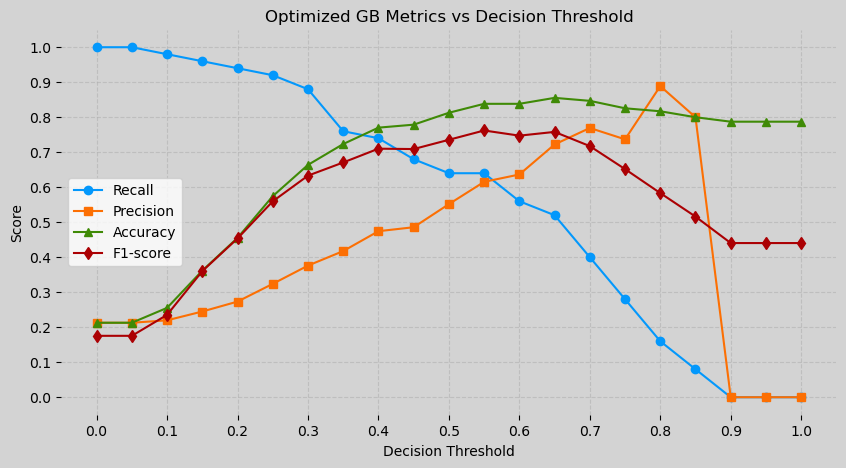

In [21]:
#Results from above minus 0.00 and 1.00
# data = {
#     "threshold": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
#                   0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95],
#     "recall": [ 0.86, 0.80, 0.72, 0.68, 0.64, 0.64, 0.60, 0.54, 0.46,
#                0.42, 0.40, 0.36, 0.34, 0.32, 0.32, 0.30, 0.24, 0.14, 0.12],
#     "precision": [ 0.36, 0.45, 0.48, 0.52, 0.55, 0.59, 0.60, 0.60, 0.57,
#                   0.57, 0.56, 0.62, 0.65, 0.64, 0.70, 0.71, 0.71, 0.70, 0.86],
#     "accuracy": [ 0.6468, 0.7489, 0.7745, 0.8000, 0.8128, 0.8298, 0.8298,
#                  0.8255, 0.8128, 0.8085, 0.8043, 0.8170, 0.8213, 0.8170, 0.8255,
#                  0.8255, 0.8170, 0.8043, 0.8085],
#     "f1": [ 0.6166, 0.6986, 0.7112, 0.7295, 0.7355, 0.7530, 0.7459,
#             0.7295, 0.6977, 0.6826, 0.6727, 0.6729, 0.6704, 0.6589, 0.6675,
#             0.6599, 0.6258, 0.5606, 0.5508,]}
df = threshold_results

#Plot Threshold Results:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.plot(df["threshold"], df["recall"], label="Recall", marker='o', color='#0398fc')
ax.plot(df["threshold"], df["precision"], label="Precision", marker='s', color='#fc6f03')
ax.plot(df["threshold"], df["accuracy"], label="Accuracy", marker='^', color='#3f8a06')
ax.plot(df["threshold"], df["f1"], label="F1-score", marker='d', color='#ab0003')
plt.title("Optimized GB Metrics vs Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()
# plt.tight_layout()
# plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/Optimized_GB_Threshold_Results')
plt.show()